In [43]:
from datasets import load_dataset, Audio, DatasetDict, Dataset, load_from_disk, IterableDatasetDict, interleave_datasets, concatenate_datasets

from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor, WhisperForConditionalGeneration, GenerationConfig, WhisperTokenizer, logging, BitsAndBytesConfig, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
# from peft import prepare_model_for_kbit_training, LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
from huggingface_hub import notebook_login, create_repo
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import multiprocess as mp
import gc
import time
import numpy as np
# import noisereduce as nr
from scipy import signal
import librosa
import evaluate
import jiwer
import os
import numba
import json
from numba import jit, cuda

import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torchaudio
from torch.nn import ZeroPad2d

from torch.utils.data import Dataset, DataLoader


In [44]:
from model import Processor, SpectroDataset, SpectrogramEncoder, UNetDecoder, STSAutoEncoder
from losses import MCDLoss, PerceptualLoss, ContrastiveLoss, AutoencoderLoss
from trainer import Trainer  # Import Trainer from the external script
from evaluation import Evaluator

In [45]:
sampling_rate = 16000
os.environ['KMP_DUPLICATE_LIB_OK']='True'
logging.set_verbosity_warning()
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.version.cuda)

Using device: cuda
12.4


In [46]:
# notebook_login()

In [94]:
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.models import EncDecRNNTModel

# asr_model_id = "nvidia/stt_it_conformer_transducer_large"
asr_model_id = "nvidia/stt_en_conformer_transducer_large"

asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(asr_model_id)
asr_model.cfg.joint['fuse_loss_wer'] = False
# asr_model.cfg.loss["max_logit_len"] = 150

asr_model.joint = EncDecRNNTModel.from_config_dict(asr_model.cfg.joint)

asr_model.to(device)

[NeMo I 2025-04-16 14:58:29 mixins:181] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-04-16 14:58:30 modelPT:180] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket4/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket5/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket6/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket7/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    

[NeMo I 2025-04-16 14:58:30 features:305] PADDING: 0
[NeMo I 2025-04-16 14:58:31 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2025-04-16 14:58:31 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-16 14:58:31 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-16 14:58:31 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-04-16 14:58:31 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-04-16 14:58:32 save_restore_connector:275] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_en_conformer_transducer_large/snapshots/a40623d1796368b64a9433bce3bcd75fce379a7b/stt_en_conformer_transducer_large.nemo.


EncDecRNNTBPEModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=10240, out_features=512, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-16): 17 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (activation): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048,

In [95]:
from model import Processor

processor = Processor(asr_model,device)

In [96]:
from lie import localized_smooth_field_1d, localized_smooth_field_2d, generate_lie_generator_fields, apply_transformation


In [97]:
import torch.nn.functional as F

def pad_spectrogram(spec, target_height=96):
    """
    Pads a spectrogram [B, 1, F, T] to height=96 (bottom-padding).
    """
    pad_height = target_height - spec.shape[2]
    return F.pad(spec, (0, 0, 0, pad_height))  # pad = (left, right, top, bottom)

def imagenet_normalize_1ch(spec):
    """
    Normalize a 1-channel [B, 1, F, T] spectrogram using ImageNet stats
    (broadcasting mean/std of grayscale version)
    """
    mean = 0.485
    std = 0.229
    return (spec - mean) / std


def normalize_spectrogram(S, min_val=-7.0, max_val=1.0):
    """
    Normalize log-Mel spectrogram from [min_val, max_val] to [0, 1]
    Input: Tensor [F, T]
    Output: Tensor [F, T]
    """
    return (S - min_val) / (max_val - min_val)

def denormalize_spectrogram(S_norm, min_val=-7.0, max_val=1.0):
    return S_norm * (max_val - min_val) + min_val


In [98]:
# field_normalization_ranges = {
#     't_stretch': 0.15,     # Approx max absolute value
#     'f_stretch': 0.15,
#     'warp_2d_v': 0.2,
#     'warp_2d_w': 0.2,
#     'amplitude': 0.3
# }


def normalize_field(field, max_abs):
    """
    Normalize a field from [-max_abs, +max_abs] → [-1, 1]
    """
    return torch.clamp(field / max_abs, min=-1.0, max=1.0)

def denormalize_field(norm_field, max_abs):
    return norm_field * max_abs



def normalize_fields(fields, norm_ranges):
    normed_fields = {}
    for key, value in fields.items():
        if key == 'warp_2d':
            v, w = value
            v_norm = normalize_field(v, norm_ranges['warp_2d'])
            w_norm = normalize_field(w, norm_ranges['warp_2d'])
            normed_fields[key] = (v_norm, w_norm)
        else:
            normed_fields[key] = normalize_field(value, norm_ranges[key])
    return normed_fields

def denormalize_fields(normed_fields, norm_ranges):
    denormed = {}
    for key, value in normed_fields.items():
        if key == 'warp_2d':
            v_norm, w_norm = value
            v = denormalize_field(v_norm, norm_ranges['warp_2d'])
            w = denormalize_field(w_norm, norm_ranges['warp_2d'])
            denormed[key] = (v, w)
        else:
            denormed[key] = denormalize_field(value, norm_ranges[key])
    return denormed


In [99]:
import segmentation_models_pytorch as smp
import torch.nn as nn

class LieFieldPredictor(nn.Module):
    def __init__(self, encoder_name='efficientnet-b0', pretrained=True, in_channels=1, out_channels=5):
        super().__init__()
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights='imagenet' if pretrained else None,
            in_channels=in_channels,
            classes=out_channels,
            activation=None  # No activation here — leave that to post-processing if needed
        )

    def forward(self, x):
        """
        Input: x of shape [B, 1, F, T] (e.g. [B, 1, 80, 512])
        Output: y of shape [B, 5, F, T] — one field per channel
        """
        return self.unet(x)


In [100]:
def apply_inverse_transform(S_distorted, pred_fields, epsilon_dict=None):
    """
    Applies the inverse transformation based on predicted Lie generator fields.

    Args:
        S_distorted: Tensor of shape [B, 1, F, T] — normalized distorted spectrogram
        pred_fields: Tensor of shape [B, 5, F, T] — predicted normalized Lie fields
        epsilon_dict: dict mapping each field to max ε (needed to rescale from [-1, 1])

    Returns:
        S_recon: Tensor of shape [B, 1, F, T] — spectrogram after inverse warp
    """

    B, C, F, T = pred_fields.shape
    device = pred_fields.device
    S_recon = S_distorted.clone()

    # print("apply_inverse_transform: S_distorted",S_distorted.shape)

    # Unnormalize fields back to real ε ranges
    if epsilon_dict is None:
        epsilon_dict = {
            't_stretch': 0.1,
            'f_stretch': 0.2,
            'warp_2d': 0.2,
            'amplitude': 0.05,
            'phase': 0.1,
        }

    # Denormalize predicted fields from [-1, 1] to [-ε, +ε]
    t_stretch = pred_fields[:, 0] * epsilon_dict['t_stretch']
    f_stretch = pred_fields[:, 1] * epsilon_dict['f_stretch']
    warp_v    = pred_fields[:, 2] * epsilon_dict['warp_2d']
    warp_w    = pred_fields[:, 3] * epsilon_dict['warp_2d']
    amplitude = pred_fields[:, 4] * epsilon_dict['amplitude']

    # print("t_stretch,f_stretch,warp_v,warp_w,amplitude shapes:")
    # print(t_stretch.shape,f_stretch.shape,warp_v.shape,warp_w.shape,amplitude.shape)

    # Reverse time and frequency stretch
    S_recon = batch_grid_warp(S_recon, -t_stretch, -f_stretch)
    # print("apply_inverse_transform: -t_stretch, -f_stretch",S_recon.shape)

    # Reverse 2D warp
    S_recon = batch_grid_warp(S_recon, -warp_v, -warp_w)
    # print("apply_inverse_transform: -warp_v, -warp_w",S_recon.shape)

    # Reverse amplitude modulation (1 / (1 + α) ≈ 1 - α for small α)
    amplitude = amplitude.unsqueeze(1) # Add channel dim
    # print("apply_inverse_transform: amplitude",amplitude.shape)
    
    S_recon = S_recon / (1.0 + amplitude).clamp(min=0.5)  # Safe division

    # print("apply_inverse_transform: S_recon",S_recon.shape)

    return S_recon



def batch_grid_warp(spectrogram, delta_t, delta_f):
    """
    Applies a batched 2D warp using delta_t and delta_f.

    Args:
        spectrogram: [B, 1, F, T]
        delta_t: [B, F, T] — time axis deformation
        delta_f: [B, F, T] — freq axis deformation

    Returns:
        Warped spectrogram [B, 1, F, T]
    """
    B, _, F_bins, T_steps = spectrogram.shape
    # print("batch_grid_warp: spectrogram",spectrogram.shape)
    device = spectrogram.device

    # Coordinate grid
    t_coords = torch.linspace(-1, 1, T_steps, device=device)
    f_coords = torch.linspace(-1, 1, F_bins, device=device)
    f_grid, t_grid = torch.meshgrid(f_coords, t_coords, indexing='ij')  # [F, T]
    f_grid = f_grid.expand(B, -1, -1)  # [B, F, T]
    t_grid = t_grid.expand(B, -1, -1)

    warped_f = f_grid + delta_f / F_bins * 2
    warped_t = t_grid + delta_t / T_steps * 2
    grid = torch.stack([warped_t, warped_f], dim=-1)  # [B, F, T, 2]

    grid_sample =  F.grid_sample(
        spectrogram,
        grid,
        mode='bilinear',
        padding_mode='border',
        align_corners=True
    )

    # print("batch_grid_warp: grid_sample",grid_sample.shape)

    return grid_sample


In [101]:
def spatial_smoothness_loss(phi, weight=1.0):
    """
    Computes isotropic gradient penalty across F and T dims.
    """
    dphi_dt = phi[:, :, :, 1:] - phi[:, :, :, :-1]  # along T
    dphi_df = phi[:, :, 1:, :] - phi[:, :, :-1, :]  # along F

    loss_t = dphi_dt.pow(2).mean()
    loss_f = dphi_df.pow(2).mean()

    return weight * (loss_t + loss_f)


def sparsity_loss(phi, weight=1.0):
    """
    L1 regularization encouraging sparse field values.
    phi: Tensor [B, C, F, T]
    """
    return weight * phi.abs().mean()


In [102]:
import torch.nn.functional as F

def cosine_field_loss(pred, target, eps=1e-8):
    # Flatten (F, T) into one dimension: [B, C, F*T]
    pred_flat = pred.view(pred.size(0), pred.size(1), -1)
    target_flat = target.view(target.size(0), target.size(1), -1)

    # Cosine similarity: [B, C]
    cos_sim = F.cosine_similarity(pred_flat, target_flat, dim=2, eps=eps)

    # Turn into loss (1 - sim), then average over batch & channels
    cos_loss = 1 - cos_sim
    return cos_loss.mean()


In [103]:
import segmentation_models_pytorch as smp
import torch.nn as nn
from collections import OrderedDict

backbone = smp.Unet(
    encoder_name="resnext50_32x4d",       # or "efficientnet-b0" or "resnet-34"
    encoder_weights="imagenet",    # pretrained!
    in_channels=1,                 # spectrogram = single channel
    classes=5                      # your scalar fields
)

# model = ClampedUnet(backbone)
model = backbone

weights = torch.load("Lie_ResNet_v3_2_10_epochs.pth",map_location=device)
state_dict = weights['model_state_dict']


state_dict
new_state_dict = []
    
for k,v in state_dict.items():
    k = k.replace('module.','')
    new_state_dict.append((k,v))

new_state_dict = OrderedDict(new_state_dict)
model.load_state_dict(new_state_dict)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [104]:
asr_datasets = IterableDatasetDict()
asr_datasets = load_dataset("miosipof/StS_Nemo_TORGO")

text_column_name = "transcription"



In [105]:
def predict(x):

    input_lengths = torch.full(
        size=(x.size(0),),  # batch size
        fill_value=x.size(-1),  # T
        dtype=torch.long
    ).to(x.device)  

    
    # print(f"input_lengths: {input_lengths}")

    encoder_out, encoded_len = asr_model(processed_signal=x.squeeze(1), processed_signal_length=input_lengths)

    # print(f"encoder_out shape: {encoder_out.shape}")
    # print(f"encoded_len: {encoded_len}")

    hypotheses = asr_model.decoding.rnnt_decoder_predictions_tensor(
    encoder_output=encoder_out,
    encoded_lengths=encoded_len)
    
    return hypotheses

In [106]:
def reconstruct(S, epsilon=0.3):
    
    print("S.shape",S.shape)

    S = S.unsqueeze(0).unsqueeze(0)
    
    S_padded = pad_spectrogram(S)
    S_norm = normalize_spectrogram(S_padded, min_val=-7.0, max_val=1.0)
    
    pred_fields = model(S_norm)
    pred_fields = pred_fields[:,:,:80,:] 

    epsilon_dict = {
        't_stretch': epsilon/2,
        'f_stretch': epsilon,
        'warp_2d': epsilon,
        'amplitude': epsilon/5,
        'phase': epsilon,
    }

    S_recon = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
    S_denorm = denormalize_spectrogram(S_recon, min_val=-7.0, max_val=1.0)  

    print("S_denorm.shape",S_denorm.shape)

    return S_denorm

    

In [107]:
def reconstruct_batched(S_batch, epsilon=0.3):
    
    

    S_batch = S_batch.unsqueeze(1) # add channel dim
    # print("reconstruct_batched: S_batch.shape",S_batch.shape)
    
    S_padded = pad_spectrogram(S_batch)
    # print("padded: S_padded.shape",S_padded.shape)
    
    S_norm = normalize_spectrogram(S_padded, min_val=-7.0, max_val=1.0)
    
    pred_fields = model(S_norm)
    pred_fields = pred_fields[:,:,:80,:] 

    epsilon_dict = {
        't_stretch': epsilon/2,
        'f_stretch': epsilon,
        'warp_2d': epsilon,
        'amplitude': epsilon/5,
        'phase': epsilon,
    }

    S_recon = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
    S_denorm = denormalize_spectrogram(S_recon, min_val=-7.0, max_val=1.0)  

    # print("S_denorm.shape",S_denorm.shape)

    return S_denorm

    

torch.Size([80, 512])


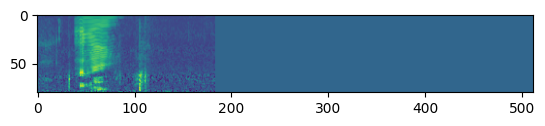

In [108]:
idx = 111
sample = asr_datasets["test"][idx]
S = torch.tensor(sample["in_spectrogram"]).to(device)

print(S.shape)

plt.figure()
plt.imshow(S.squeeze().detach().cpu())
plt.show()

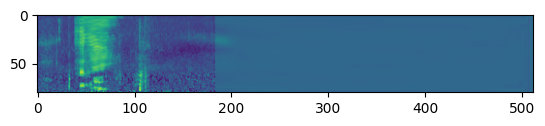

In [111]:
# S_recon = reconstruct(S,epsilon=3.0)

S_batch = torch.stack([S,S], dim=0)
S_recon = reconstruct_batched(S_batch, epsilon=4.0)

plt.figure()
plt.imshow(S_recon[0].squeeze().detach().cpu())
plt.show()

In [112]:
def normalize_text(text):
    """Standardize text (lowercase, remove punctuation, trim spaces)"""
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

In [23]:
# def preprocess_commonvoice(sample):
#     wf = sample['audio']['array']
#     S = processor.preprocess_nemo_single(wf)
#     S = S.squeeze(0)
#     sample['in_spectrogram'] = S
#     return sample
    

# commonvoice_ds = load_dataset('miosipof/CommonVoice_EN_min',split="train")
# commonvoice_ds.rename_column('sentence','transcription')

# len_ds = len(commonvoice_ds)
# commonvoice_ds = commonvoice_ds.select(range(len_ds-5000,len_ds))
# commonvoice_ds.add_column('in_spectrogram',len(commonvoice_ds)*[0])

# commonvoice_ds = commonvoice_ds.map(preprocess_commonvoice)



In [24]:
# create_repo('miosipof/CommonVoice_STS_EN_min', repo_type="dataset")
# commonvoice_ds.push_to_hub('miosipof/CommonVoice_STS_EN_min',split="train")

In [25]:
# def preprocess_uaspeech(sample):
#     wf = sample['speech']
#     S = processor.preprocess_nemo_single(wf)
#     S = S.squeeze(0)
#     sample['in_spectrogram'] = S
#     return sample


# uaspeech_ds = load_dataset('ngdiana/uaspeech_severity_high',split="train")
# uaspeech_ds = uaspeech_ds.rename_column('target','transcription')
# uaspeech_ds = uaspeech_ds.select(range(5000))

# uaspeech_ds.add_column('in_spectrogram',len(uaspeech_ds)*[0])
# uaspeech_ds = uaspeech_ds.map(preprocess_uaspeech)

In [26]:
# create_repo('miosipof/uaspeech_min', repo_type="dataset")

# uaspeech_ds.push_to_hub('miosipof/uaspeech_min',split="train")

In [58]:
torgo_ds = asr_datasets['train'].select(range(5000))

In [113]:
uaspeech_ds = load_dataset('miosipof/uaspeech_min',split="train")
uaspeech_ds = uaspeech_ds.rename_column('target','transcription')


README.md:   0%|          | 0.00/524 [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/289M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/284M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
commonvoice_ds = load_dataset('miosipof/CommonVoice_STS_EN_min',split="train")
commonvoice_ds = commonvoice_ds.rename_column('sentence','transcription')


In [28]:
# eval_dataset = asr_datasets["train"].shuffle() #.select(range(1000))
# text_column_name = 'transcription'

# eval_dataset = datasets["train"].select(range(500))
# text_column_name = 'sentence'

In [59]:
import evaluate as evaluate_lib
from jiwer import wer
import numpy as np
import re



def run_inference(model,asr_model,eval_dataset,eps=1.0,batch_size=2,text_column_name = 'transcription'):

    model.eval()
    asr_model.eval()
    
    metric = evaluate_lib.load("wer")
    cer_metric = evaluate_lib.load("cer")
    
    in_wers = []
    in_cers = []
    in_status = []
    in_texts = []
    new_wers = []
    new_cers = []
    new_status = []
    new_texts = []
    refs = []

    num_batches = len(eval_dataset)//batch_size
    
    with torch.no_grad():
        for j in range(num_batches-1):

            if batch_size > 1:
                batch = eval_dataset.select(range(j*batch_size, (j+1)*batch_size))
            else:
                batch = [eval_dataset[j]]
    
            reference_texts = [sample[text_column_name] for sample in batch]
            reference_texts = [normalize_text(reference_text) for reference_text in reference_texts]

            
            S_batch = [torch.tensor(sample["in_spectrogram"]).to(device) for sample in batch]
            S_batch = [processor.pad_spectrogram(S.unsqueeze(0)).squeeze(0) for S in S_batch]
            S_batch = torch.stack(S_batch, dim=0)

    
            in_hypotheses = predict(S_batch.squeeze(1).to(device))
            in_pred = [normalize_text(hyp.text) for hyp in in_hypotheses]


            wer_in = []
            cer_in = []
            for i, text in enumerate(reference_texts):
                wer_in.append(metric.compute(references=[text], predictions=[in_pred[i]]))
                cer_in.append(cer_metric.compute(references=[text], predictions=[in_pred[i]]))
            
            # threshold = 0.5 # apply strong transformations only for samples with WER > threshold
            # eps_max = 3.0
            # b = 2.0
            # dynamic_epsilon = eps_max * torch.sigmoid(b * (wer_in - torch.tensor(threshold)))
    
            dynamic_epsilon = eps
            
            S_recon = reconstruct_batched(S_batch,epsilon=dynamic_epsilon).squeeze(1) # Get rid of the channel dim    
            # S_recon = sharpen(S_recon, alpha=0.5)
            
            new_hypotheses = predict(S_recon.to(device))
            new_pred = [normalize_text(hyp.text) for hyp in new_hypotheses]
            
            wer_new = []
            cer_new = []
            for i, text in enumerate(reference_texts):
                wer_new.append(metric.compute(references=[text], predictions=[new_pred[i]]))
                cer_new.append(cer_metric.compute(references=[text], predictions=[new_pred[i]]))
    
            in_wers.extend(wer_in)
            in_cers.extend(cer_in)
            in_texts.extend(in_pred)
            new_wers.extend(wer_new)
            new_cers.extend(cer_new)
            new_texts.extend(new_pred)
            refs.extend(reference_texts)
            
            if batch_size == 1:
                in_stat = 0 if in_hypotheses[0].text == '' else 1
                new_stat = 0 if new_hypotheses[0].text == '' else 1
        
                in_status.append(in_stat)
                new_status.append(new_stat)
    
            if j%50 == 0:

                for i, sample in enumerate(batch):
                    print(f"Batch {j}/{num_batches}, sample {i}")
                    print(f"WER: {wer_in[i]*100:.2f}%-->{wer_new[i]*100:.2f}%")
                    print(f"CER: {cer_in[i]*100:.2f}%-->{cer_new[i]*100:.2f}%")
              
                    print(f"TRUE: {reference_texts[i]}")
                    print(f"BASE: {in_hypotheses[i].text}")
                    print(f"_NEW: {new_hypotheses[i].text}")
        
                    print(f"Eps: {dynamic_epsilon:.2f}")
            
                    print("\n")


    result = {
    'in_wers': in_wers,
    'in_cers': in_cers,
    'in_status': in_status,
    'in_texts': in_texts,
    'new_wers': new_wers,
    'new_cers': new_cers,
    'new_status': new_status,
    'new_texts': new_texts,
    'refs': refs
    }

    return result
    

In [126]:
# torgo_ds
# uaspeech_ds

result = run_inference(model,asr_model,uaspeech_ds,eps=3.0,batch_size=20)

Batch 0/250, sample 0
WER: 100.00%-->100.00%
CER: 100.00%-->85.71%
TRUE: moisten
BASE: 
_NEW: can
Eps: 3.00


Batch 0/250, sample 1
WER: 300.00%-->100.00%
CER: 72.73%-->90.91%
TRUE: abbreviated
BASE: ko wei yes
_NEW: yes
Eps: 3.00


Batch 0/250, sample 2
WER: 100.00%-->100.00%
CER: 42.86%-->85.71%
TRUE: without
BASE: with
_NEW: was
Eps: 3.00


Batch 0/250, sample 3
WER: 100.00%-->100.00%
CER: 80.00%-->80.00%
TRUE: casualties
BASE: can
_NEW: can
Eps: 3.00


Batch 0/250, sample 4
WER: 100.00%-->100.00%
CER: 100.00%-->87.50%
TRUE: downward
BASE: 
_NEW: fire
Eps: 3.00


Batch 0/250, sample 5
WER: 100.00%-->100.00%
CER: 100.00%-->75.00%
TRUE: each
BASE: 
_NEW: eight
Eps: 3.00


Batch 0/250, sample 6
WER: 100.00%-->100.00%
CER: 100.00%-->166.67%
TRUE: how
BASE: 
_NEW: eight
Eps: 3.00


Batch 0/250, sample 7
WER: 100.00%-->100.00%
CER: 100.00%-->100.00%
TRUE: absolve
BASE: 
_NEW: 
Eps: 3.00


Batch 0/250, sample 8
WER: 100.00%-->100.00%
CER: 100.00%-->100.00%
TRUE: thumb
BASE: 
_NEW: seven
Ep

In [127]:
import pandas as pd


if len(result['in_status']) == 0:
    del result['in_status']
    del result['new_status']

    
resulf_df = pd.DataFrame.from_dict(result)

resulf_df.to_csv("Lie_ResNet_v3_2_10_epochs_UASPEECH.csv")

In [128]:
def word_count(text: str) -> int:
    """Count how many words in `text`, splitting on whitespace."""
    return len(text.split())

def char_count(text: str) -> int:
    """Count total characters, ignoring spaces if you want (optional)."""
    # If ignoring spaces:
    text_no_spaces = text.replace(" ", "")
    return len(text_no_spaces)


In [129]:
import numpy as np

refs = result['refs']  # e.g. list of reference strings
n_samples = len(refs)

word_counts = [word_count(r) for r in refs]  # e.g. [3, 5, 6, ...]
char_counts = [char_count(r) for r in refs]  # e.g. [15, 23, ...]

total_words = sum(word_counts)
total_chars = sum(char_counts)


in_wers = result['in_wers']   # shape [n_samples]
new_wers = result['new_wers']

in_errors_word = 0.0
new_errors_word = 0.0

for i in range(n_samples):
    in_errors_word += in_wers[i] * word_counts[i]
    new_errors_word += new_wers[i] * word_counts[i]


in_cers = result['in_cers']
new_cers = result['new_cers']

in_errors_char = 0.0
new_errors_char = 0.0

for i in range(n_samples):
    in_errors_char += in_cers[i] * char_counts[i]
    new_errors_char += new_cers[i] * char_counts[i]


wer_in_global = in_errors_word / (total_words if total_words > 0 else 1)
wer_new_global = new_errors_word / (total_words if total_words > 0 else 1)

print(f"BASE global WER: {wer_in_global:.3f}")
print(f"NEW global WER: {wer_new_global:.3f}")

cer_in_global = in_errors_char / (total_chars if total_chars > 0 else 1)
cer_new_global = new_errors_char / (total_chars if total_chars > 0 else 1)

print(f"In system global CER: {cer_in_global:.3f}")
print(f"New system global CER: {cer_new_global:.3f}")


BASE global WER: 1.165
NEW global WER: 1.130
In system global CER: 0.884
New system global CER: 0.885


In [130]:
improvements = resulf_df[resulf_df['new_wers'] < resulf_df['in_wers']]

for i,row in improvements.iterrows():
    if row['new_texts'] != '':
        print(f"TRUE: {row['refs']}")
        print(f"BASE: {row['in_texts']}")
        print(f"PRED: {row['new_texts']}\n\n")

TRUE: abbreviated
BASE: ko wei yes
PRED: yes


TRUE: episode
BASE: have been sold
PRED: happy sewed


TRUE: nine
BASE: nine nine
PRED: nine


TRUE: are
BASE: oh oh
PRED: four


TRUE: many
BASE: lily
PRED: many


TRUE: seven
BASE: sap fin
PRED: sapin


TRUE: people
BASE: 
PRED: people


TRUE: coil
BASE: go long go
PRED: colonel


TRUE: them
BASE: dam dam
PRED: m


TRUE: one
BASE: nine
PRED: one


TRUE: candlelight
BASE: king too
PRED: k


TRUE: vacuum
BASE: thank you
PRED: five


TRUE: five
BASE: 
PRED: five


TRUE: whiskey
BASE: we see
PRED: we


TRUE: tango
BASE: then go
PRED: ten


TRUE: is
BASE: yes yes
PRED: yes


TRUE: nine
BASE: no um
PRED: no


TRUE: tango
BASE: can come
PRED: can


TRUE: hotel
BASE: old town
PRED: oh


TRUE: authoritative
BASE: i so thank you
PRED: i so


TRUE: bloodshed
BASE: but loud shout
PRED: but


TRUE: lethargy
BASE: let lo
PRED: lah


TRUE: gigantic
BASE: sure can
PRED: can


TRUE: toil
BASE: t all long
PRED: all along


TRUE: way
BASE: one one
PRED: on

In [131]:
from scipy.stats import ttest_rel, wilcoxon


print(f"WER: {np.mean(result['in_wers'])}-->{np.mean(result['new_wers'])}")
print(f"CER: {np.mean(result['in_cers'])}-->{np.mean(result['new_cers'])}")

print(f"Median WER: {np.median(result['in_wers'])}-->{np.median(result['new_wers'])}")
print(f"Median CER: {np.median(result['in_cers'])}-->{np.median(result['new_cers'])}")

_, p_wer = ttest_rel(result['in_wers'], result['new_wers'])
_, p_cer = ttest_rel(result['in_cers'], result['new_cers'])

print(f"WER p-value: {p_wer}, CER p-value: {p_cer}")

WER: 1.1652610441767068-->1.1295180722891567
CER: 0.9023511433903001-->0.9058141122598954
Median WER: 1.0-->1.0
Median CER: 1.0-->1.0
WER p-value: 8.133119499017702e-09, CER p-value: 0.5212939124768103


In [132]:
improved = sum(1 for i in range(len(result['in_wers'])) if result['new_wers'][i] < result['in_wers'][i])
worsened = sum(1 for i in range(len(result['in_wers'])) if result['new_wers'][i] > result['in_wers'][i])
same = sum(1 for i in range(len(result['in_wers'])) if result['new_wers'][i] == result['in_wers'][i])

net_gain = improved - worsened
print(f"Improved: {improved}, Worsened: {worsened}, Net gain: {net_gain}")

improved_value = sum([result['in_wers'][i] - result['new_wers'][i] for i in range(len(result['in_wers'])) if result['new_wers'][i] < result['in_wers'][i]])
worsened_value = sum([result['in_wers'][i] - result['new_wers'][i] for i in range(len(result['in_wers'])) if result['new_wers'][i] > result['in_wers'][i]])

print(f"Improved value: {improved_value:.4f}, Worsened value: {worsened_value:.4f}, Net gain value: {improved_value + worsened_value:.4f}")

Improved: 478, Worsened: 309, Net gain: 169
Improved value: 509.0000, Worsened value: -331.0000, Net gain value: 178.0000


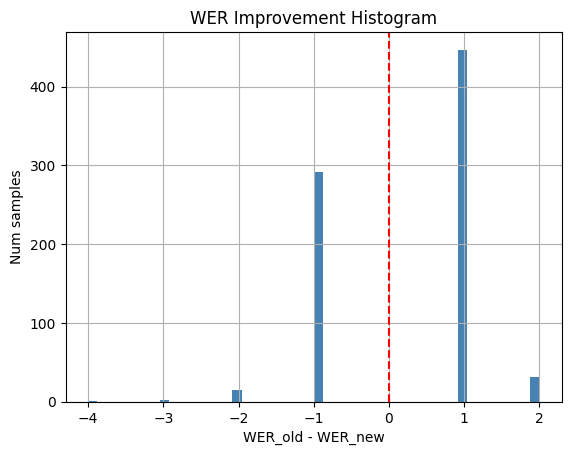

In [133]:
import matplotlib.pyplot as plt
deltas = [old - new for old, new in zip(result['in_wers'], result['new_wers']) if old != new]

plt.hist(deltas, bins=50, color='steelblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("WER Improvement Histogram")
plt.xlabel("WER_old - WER_new")
plt.ylabel("Num samples")
plt.grid(True)
plt.show()

In [134]:
threshold = 0.99
wrong_base = {i for i, w in enumerate(result['in_wers']) if w > threshold}
wrong_new = {i for i, w in enumerate(result['new_wers']) if w > threshold}

fixed_by_model = wrong_base - wrong_new
broken_by_model = wrong_new - wrong_base
print(f"Fixed: {len(fixed_by_model)}, New errors: {len(broken_by_model)}")



Fixed: 87, New errors: 156


In [135]:
print("\nWER filtered (only samples with both new and old WER < 300%):")

in_wers_filtered = []
new_wers_filtered = []
for i, w in enumerate(in_wers):
    if result['in_wers'][i] < 3.0 and result['new_wers'][i] < 3.0:
        in_wers_filtered.append(result['in_wers'][i])
        new_wers_filtered.append(result['new_wers'][i])

print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")



print("\nCER filtered (only samples with both new and old CER < 200%):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(in_cers):
    if result['in_cers'][i] < 2.0 and result['new_cers'][i] < 2.0:
        in_cers_filtered.append(result['in_cers'][i])
        new_cers_filtered.append(result['new_cers'][i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}")


WER filtered (only samples with both new and old WER < 300%):
WER (4757 samples): 1.0887113727138953-->1.0523439142316586

CER filtered (only samples with both new and old CER < 200%):
CER (4775 samples): 0.8604485921292203-->0.8726989764162537


In [136]:
# Paired t-test or Wilcoxon (non-parametric)
from scipy.stats import ttest_rel, wilcoxon

_, p_wer = ttest_rel(in_wers_filtered, new_wers_filtered)
_, p_cer = ttest_rel(in_cers_filtered, new_cers_filtered)

print(f"Filtered WER p-value: {p_wer}, Filtered CER p-value: {p_cer}")

Filtered WER p-value: 2.5008674754807198e-11, Filtered CER p-value: 0.004715986060424369


In [137]:
wer_treshold = 0.5
cer_treshold = 0.3

print(f"\nWER filtered (only samples with old WER > {wer_treshold*100}%):")

in_wers_filtered = []
new_wers_filtered = []
for i, w in enumerate(in_wers):
    if result['in_wers'][i] > wer_treshold:
        in_wers_filtered.append(result['in_wers'][i])
        new_wers_filtered.append(result['new_wers'][i])

print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")



print(f"\nCER filtered (only samples with old CER > {cer_treshold*100}%):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(in_cers):
    if result['in_cers'][i] > cer_treshold:
        in_cers_filtered.append(result['in_cers'][i])
        new_cers_filtered.append(result['new_cers'][i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}")


WER filtered (only samples with old WER > 50.0%):
WER (4695 samples): 1.2359957401490949-->1.164856230031949

CER filtered (only samples with old CER > 30.0%):
CER (4651 samples): 0.9639773584355396-->0.932127139684654


In [92]:
# Paired t-test or Wilcoxon (non-parametric)
from scipy.stats import ttest_rel, wilcoxon

_, p_wer = ttest_rel(in_wers_filtered, new_wers_filtered)
_, p_cer = ttest_rel(in_cers_filtered, new_cers_filtered)

print(f"Filtered WER p-value: {p_wer}, Filtered CER p-value: {p_cer}")

Filtered WER p-value: 8.143355851725016e-99, Filtered CER p-value: 1.1708871405488527e-61


In [42]:
cleaned_results = resulf_df[resulf_df['in_status'] == 1]
cleaned_results = cleaned_results[cleaned_results['new_status'] == 1]

len(cleaned_results)

print(f"WER ({len(cleaned_results)} cleaned samples): \n{np.mean(cleaned_results['in_wers'])}-->{np.mean(cleaned_results['new_wers'])}")
print(f"CER ({len(cleaned_results)} cleaned samples): \n{np.mean(cleaned_results['in_cers'])}-->{np.mean(cleaned_results['new_cers'])}")

_, p_wer = ttest_rel(cleaned_results['in_wers'], cleaned_results['new_wers'])
_, p_cer = ttest_rel(cleaned_results['in_cers'], cleaned_results['new_cers'])

print(f"Cleaned WER p-value: {p_wer} \nCleaned CER p-value: {p_cer}")


KeyboardInterrupt



In [68]:
whisper_model_id = "openai/whisper-medium"
whisper = WhisperForConditionalGeneration.from_pretrained(whisper_model_id).to(device)
whisper_processor = WhisperProcessor.from_pretrained(whisper_model_id, language="en", task="transcribe")


config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [79]:
def predict_whisper(S):
    
        S = S.to(device).unsqueeze(0)  # Add batch dim & move to GPU

        forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="en", task="transcribe")
    
        generated_ids = whisper.generate(
            S,
            do_sample=False,  # Disable randomness
            num_beams=3,      # Greedy decoding
            temperature=0.0,   # No sampling
            forced_decoder_ids=forced_decoder_ids,  # Force Italian language token
        )
        pred_text = whisper_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
        # Normalize both reference and predicted text
        pred_text = normalize_text(pred_text)

        return pred_text

In [84]:
import evaluate as evaluate_lib
from jiwer import wer
import numpy as np
import torch.nn.functional as F

model.eval()
asr_model.eval()

metric = evaluate_lib.load("wer")
cer_metric = evaluate_lib.load("cer")

in_wers = []
in_cers = []
in_status = []
in_texts = []
new_wers = []
new_cers = []
new_status = []
new_texts = []
refs = []

with torch.no_grad():
    for j, sample in enumerate(eval_dataset):

        reference_text = sample['transcription']

        S = torch.tensor(sample["in_spectrogram"]).to(device)
        pred_text_in = predict_whisper(S)

        S_recon = reconstruct(S,epsilon=0.3).squeeze(1) # Get rid of the channel dim
        S_recon = S_recon.squeeze() 
        pred_text_new = predict_whisper(S_recon)
                
        wer_in = metric.compute(references=[reference_text], predictions=[pred_text_in])
        cer_in = cer_metric.compute(references=[reference_text], predictions=[pred_text_in])

        wer_new = metric.compute(references=[reference_text], predictions=[pred_text_new])
        cer_new = cer_metric.compute(references=[reference_text], predictions=[pred_text_new])

        d_wer = (wer_new - wer_in)/wer_in if wer_in > 0 else (wer_new - wer_in)/(wer_new + 1e-7)
        d_cer = (cer_new - cer_in)/cer_in if cer_in > 0 else (cer_new - cer_in)/(cer_new + 1e-7)

        in_wers.append(wer_in)
        in_cers.append(cer_in)
        in_texts.append(in_pred)
        new_wers.append(wer_new)
        new_cers.append(cer_new)
        new_texts.append(new_pred)
        refs.append(reference_text)

        in_stat = 0 if len(pred_text_in) > 2*len(reference_text) else 1
        new_stat = 0 if len(pred_text_in) > 2*len(reference_text) else 1

        in_status.append(in_stat)
        new_status.append(new_stat)
        
        print(f"Sample {j}/{len(eval_dataset)}")
        print(f"WER: {wer_in*100:.2f}%-->{wer_new*100:.2f}% ({d_wer:.4f})")
        print(f"CER: {cer_in*100:.2f}%-->{cer_new*100:.2f}% ({d_cer:.4f})")

        
        print(f"TRUE: {reference_text}")
        print(f"BASE: {pred_text_in}")
        print(f"NEW: {pred_text_new}")

        print("\n")





Sample 0/100
WER: 200.00%-->100.00% (-0.5000)
CER: 166.67%-->100.00% (-0.4000)
TRUE: top
BASE: im out
NEW: bye


Sample 1/100
WER: 100.00%-->100.00% (0.0000)
CER: 75.00%-->75.00% (0.0000)
TRUE: knew
BASE: bye
NEW: bye


Sample 2/100
WER: 300.00%-->400.00% (0.3333)
CER: 360.00%-->300.00% (-0.1667)
TRUE: group
BASE: thanks for watching
NEW: see you next time


Sample 3/100
WER: 300.00%-->300.00% (0.0000)
CER: 425.00%-->425.00% (0.0000)
TRUE: rake
BASE: thanks for watching
NEW: thanks for watching


Sample 4/100
WER: 600.00%-->700.00% (0.1667)
CER: 140.00%-->200.00% (0.4286)
TRUE: store
BASE: s t r o w e
NEW: s t r o i n g


Sample 5/100
WER: 200.00%-->1100.00% (4.5000)
CER: 220.00%-->960.00% (3.3636)
TRUE: droop
BASE: youre welcome
NEW: thanks for watching and ill see you in the next one


Sample 6/100
WER: 100.00%-->1100.00% (10.0000)
CER: 100.00%-->1633.33% (15.3333)
TRUE: tip
BASE: beep
NEW: thanks for watching and ill see you in the next one


Sample 7/100
WER: 100.00%-->300.00% (2.0


KeyboardInterrupt



In [ ]:
whisper_result = {
'in_wers': in_wers,
'in_cers': in_cers,
'in_status': in_status,
'in_texts': in_texts,
'new_wers': new_wers,
'new_cers': new_cers,
'new_status': new_status,
'new_texts': new_texts,
'refs': refs
}


whisper_resulf_df = pd.DataFrame.from_dict(whisper_result)